##### To develop a hybrid anomaly detection model using a sparse autoencoder, Isolation Forest, and XGBoost in sequence, begin by loading and cleaning your data. Select important features and split the dataset into training and testing sets. Normalize these features through feature scaling. Use a sparse autoencoder to reduce the dimensionality of your data, enhancing manageability and focus. Apply an Isolation Forest to effectively identify initial anomalies, and then refine the detection with XGBoost, a powerful classifier that improves the model's sensitivity and accuracy. Evaluate the model's performance using precision, recall, F1-score, and a confusion matrix. This approach combines the strengths of dimensionality reduction, anomaly isolation, and advanced classification to effectively detect anomalies in diverse data scenarios.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

Epoch 1/50
138/138 [==============================] - 1s 2ms/step - loss: 0.0620 - val_loss: 0.0415
Epoch 2/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0332 - val_loss: 0.0260
Epoch 3/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0206 - val_loss: 0.0163
Epoch 4/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0107
Epoch 5/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0090 - val_loss: 0.0075
Epoch 6/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0058
Epoch 7/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 8/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 9/50
138/138 [==============================] - 0s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/50
138/138 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0035

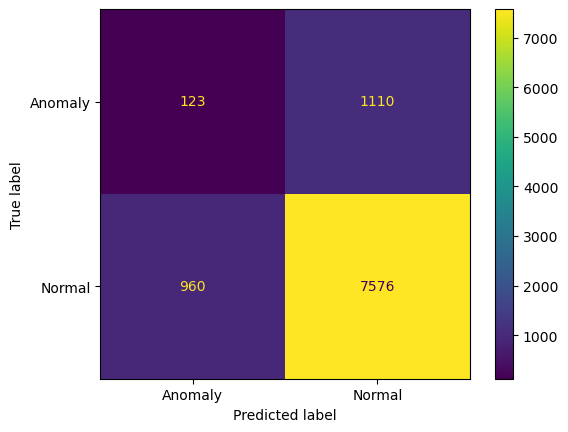

In [3]:

def complete_anomaly_detection_system():
    # Load and preprocess data
    data = pd.read_csv('adultdata.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    data = data.drop('Sex', axis=1)
    
    X = data.drop('fnlwgt', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['fnlwgt']
    
    y = np.where(y_cont > 80000, 1, 0)  # Define `threshold` based on your domain knowledge
    
    # Select top k features; k might be adjusted based on the dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    #data.info()


    data.dropna(axis=0, inplace=True)
    
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Define and train the autoencoder
    input_dim = X_scaled.shape[1]
    encoding_dim = 32
    input_layer = tf.keras.Input(shape=(input_dim,))
    encoded = layers.Dense(encoding_dim, activation='relu', 
                           activity_regularizer=regularizers.l1(10e-5))(input_layer)
    decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = models.Model(input_layer, decoded)
    encoder = models.Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.1, verbose=1)

    # Encode the data
    X_train_encoded = encoder.predict(X_train)
    X_test_encoded = encoder.predict(X_test)
    
    # Train XGBoost on the encoded data
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    xgb.fit(X_train_encoded, y_train)
    
    # Predict with XGBoost to filter normal data
    xgb_predictions_train = xgb.predict(X_train_encoded)
    normal_indices = (xgb_predictions_train == 1)
    X_train_normal = X_train_encoded[normal_indices]
    
    # Train Isolation Forest on the filtered normal data
    iso_forest = IsolationForest(random_state=42)
    iso_forest.fit(X_train_normal)
    
    # Predict on the entire test dataset with Isolation Forest
    if_predictions = iso_forest.predict(X_test_encoded)
    if_predictions = np.where(if_predictions == 1, 1, 0)  # Convert predictions to binary
    
    # Evaluate the model
    precision = precision_score(y_test, if_predictions, pos_label=0)
    recall = recall_score(y_test, if_predictions, pos_label=0)
    f1 = f1_score(y_test, if_predictions, pos_label=0)
    
    
    print(classification_report(y_test, if_predictions))
    

    # Output the metrics
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")

    # Display the confusion matrix
    cm = confusion_matrix(y_test, if_predictions, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()

# Example usage
# Ensure your CSV file is at the specified path and correctly formatted
complete_anomaly_detection_system()
